In [ ]:
#@title Mount Google Drive {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Setting random seeds to reduce the amount of randomness in the neural net weights and results
# The results may still not be exactly reproducible

np.random.seed(42)
tf.random.set_seed(42)

**Ensure that the Runtime Type for this notebook is set to GPU**.

Run the code below to check for GPU. If a GPU device is not found, change the runtime type under *Runtime* &#10141; *Change runtime type* &#10141; *Hardware accelerator* &#10141; *GPU* and run the notebook from the beginning again.

In [ ]:
# Testing to ensure GPU is being utilized.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Deep Learning: Building Age CNN Model

**Our age prediction CNN model shall be defined and trained**:
1. with **grayscale images** instead of RGB coloured images.
2. with **augmented training dataset (234,400 images)** instead of original training dataset (23,440 images).
3. for **60 epochs**.
4. for **distributed classes of age-ranges**.
5. with an **optimized architecture**, comprising of:
- an input *Conv2D* layer (with 32 filters) paired with an *AveragePooling2D* layer,
- 3 pairs of *Conv2D* (with 64, 128 & 256 filters) and *AveragePooling2D* layers,
- a *GlobalAveragePooling2D* layer,
- 1 *Dense* layer with 132 nodes, and
- an output *Dense* layer with 7 nodes.

In [ ]:
# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/input/combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [ ]:
# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/input/combined_faces_train_augmented.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces_train_augmented.zip


In [ ]:
# Importing the augmented training dataset and testing dataset to create tensors of images using the filename paths.

train_aug_df = pd.read_csv("/content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/input/images_filenames_labels_train_augmented.csv")
test_df = pd.read_csv("/content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/input/images_filenames_labels_test.csv")

In [ ]:
train_aug_df.head()

,filename,age
0,/content/content/combined_faces_train_augmente...,43
1,/content/content/combined_faces_train_augmente...,71
2,/content/content/combined_faces_train_augmente...,6
3,/content/content/combined_faces_train_augmente...,18
4,/content/content/combined_faces_train_augmente...,25


In [ ]:
test_df.head()

,filename,age
0,/content/content/combined_faces/8_163.jpg,8
1,/content/content/combined_faces/38_66.jpg,38
2,/content/content/combined_faces/40_177.jpg,40
3,/content/content/combined_faces/36_267.jpg,36
4,/content/content/combined_faces/8_349.jpg,8


In [ ]:
# Dropping the age column since classes of age-ranges have been re-distributed from 11 to 7 classes.

# train_aug_df.drop(columns=['target'], inplace=True)
# train_aug_df.head()

In [ ]:
# Dropping the age column since classes of age-ranges have been re-distributed from 11 to 7 classes.

# test_df.drop(columns=['target'], inplace=True)
# test_df.head()

In [ ]:
train_aug_df.shape

(234400, 2)

In [ ]:
test_df.shape

(10046, 2)

In [ ]:
# Defining a function to return the class labels corresponding to the re-distributed 7 age-ranges.

def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [ ]:
train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [ ]:
train_aug_df.head()

,filename,age,target
0,/content/content/combined_faces_train_augmente...,43,4
1,/content/content/combined_faces_train_augmente...,71,6
2,/content/content/combined_faces_train_augmente...,6,1
3,/content/content/combined_faces_train_augmente...,18,2
4,/content/content/combined_faces_train_augmente...,25,3


In [ ]:
test_df.head()

,filename,age,target
0,/content/content/combined_faces/8_163.jpg,8,1
1,/content/content/combined_faces/38_66.jpg,38,4
2,/content/content/combined_faces/40_177.jpg,40,4
3,/content/content/combined_faces/36_267.jpg,36,4
4,/content/content/combined_faces/8_349.jpg,8,1


In [ ]:
train_aug_df['target'].value_counts(normalize=True)

4    0.279394
3    0.199829
5    0.167193
0    0.095307
2    0.093643
1    0.084087
6    0.080546
Name: target, dtype: float64

In [ ]:
test_df['target'].value_counts(normalize=True)

4    0.279415
3    0.199781
5    0.167131
0    0.095361
2    0.093669
1    0.084113
6    0.080530
Name: target, dtype: float64

In [ ]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.

train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [ ]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the architecture of the sequential neural network.

final_cnn = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
final_cnn.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
final_cnn.add(Dense(132, activation='relu'))

# Output layer with 7 nodes (equal to the no. of classes).
final_cnn.add(Dense(7, activation='softmax'))

final_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
average_pooling2d_2 (Average (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 256)       2

In [ ]:
# Compiling the above created CNN architecture.

final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Creating a TensorBoard callback object and saving it at the desired location.

tensorboard = TensorBoard(log_dir=f"/content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs")

We shall also use ***ModelCheckpoint*** as a callback while training the final CNN model so as to be able to save the model as it continues training and improving in performance over 60 epochs.

In [ ]:
# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath=f"/content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [ ]:
# Fitting the above created CNN model.

final_cnn_history = final_cnn.fit(train_aug_dataset,
                                  batch_size=512,
                                  validation_data=test_dataset,
                                  epochs=60,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/60
458/458 [==============================] - 168s 322ms/step - loss: 1.7905 - accuracy: 0.3049 - val_loss: 1.5949 - val_accuracy: 0.3609

Epoch 00001: val_accuracy improved from -inf to 0.36094, saving model to /content/drive/My Drive/Project5_Computer_Vision_in_Retail/1.1_age_input_output/output/age_model_checkpoint.h5
Epoch 2/60
458/458 [==============================] - 135s 295ms/step - loss: 1.5402 - accuracy: 0.3806 - val_loss: 1.4289 - val_accuracy: 0.4215

Epoch 00002: val_accuracy improved from 0.36094 to 0.42146, saving model to /content/drive/My Drive/Project5_Computer_Vision_in_Retail/1.1_age_input_output/output/age_model_checkpoint.h5
Epoch 3/60
458/458 [==============================] - 135s 295ms/step - loss: 1.3218 - accuracy: 0.4594 - val_loss: 1.2703 - val_accuracy: 0.4774

Epoch 00003: val_accuracy improved from 0.42146 to 0.47740, saving model to /content/drive/My Drive/Project5_Computer_Vision_in_Retail/1.1_age_input_output/output/age_model_checkpoint.h5
E

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

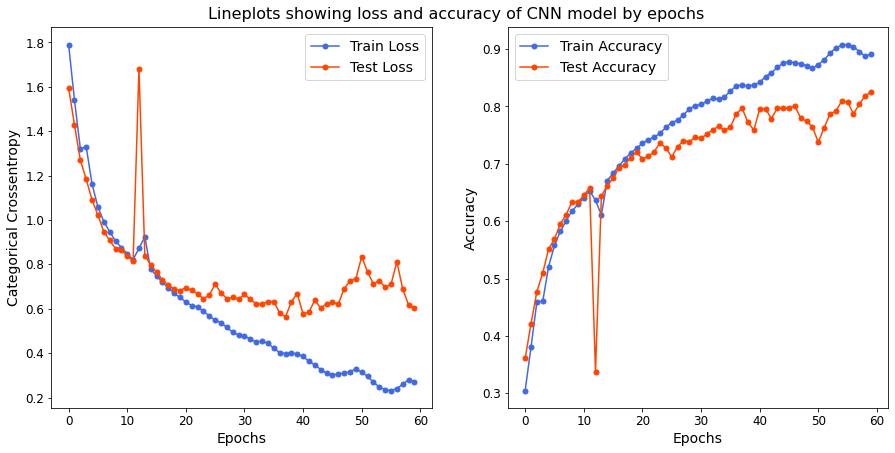

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/final_cnn_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 2s 95ms/step - loss: 0.6058 - accuracy: 0.8252


In [ ]:
# Printing the relevant score summary.

final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

CNN model loss 		= 0.606
CNN model accuracy 	= 0.825


In [ ]:
# Saving the model as a h5 file for possible use later.

final_cnn.save(f"/content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/age_model_acc_{round(final_cnn_score[1], 3)}.h5", save_format='h5')

In [ ]:
# Generating predictions from the model above.

final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

In [ ]:
len(final_cnn_pred)

10046

In [ ]:
len(test_labels_list)

10046

In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)
conf_mat

array([[ 891,   62,    0,    1,    2,    2,    0],
       [  11,  817,   11,    2,    3,    1,    0],
       [   0,   72,  782,   55,   28,    4,    0],
       [   2,   33,  100, 1376,  463,   33,    0],
       [   1,   17,   46,  262, 2303,  171,    7],
       [   0,    1,   11,   16,  179, 1391,   81],
       [   0,    1,    0,    1,   11,   66,  730]])

In [ ]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


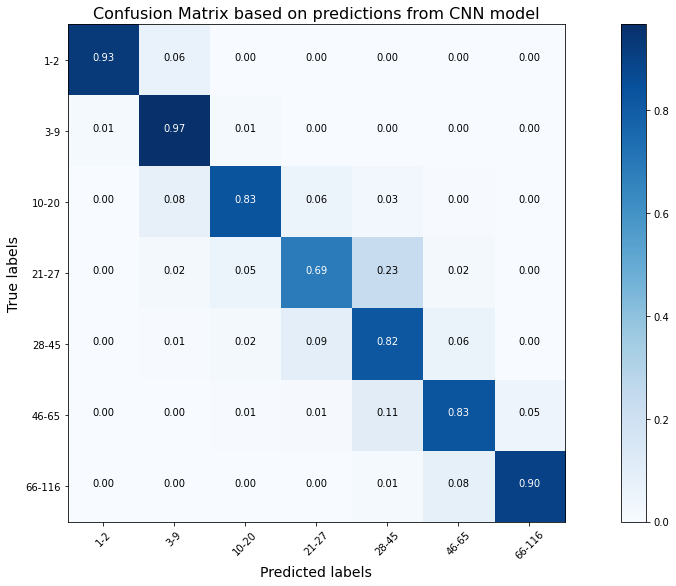

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )

plt.show()

Confusion matrix, without normalization


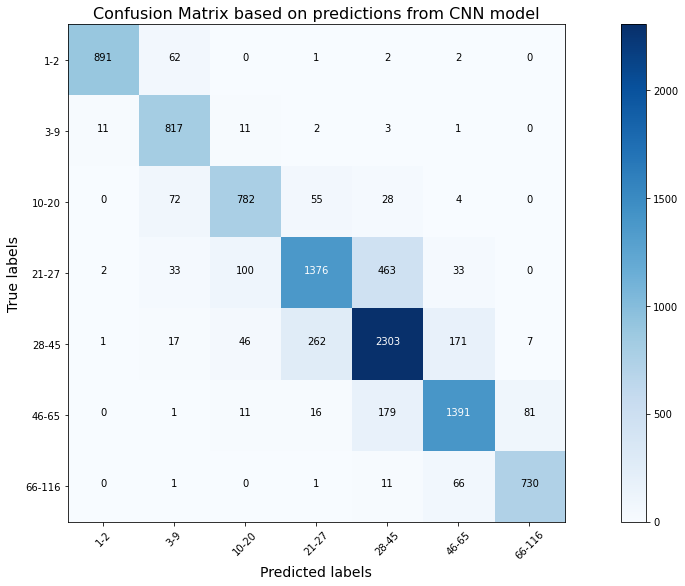

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat"
                     )

plt.show()

As seen in the lineplots above, the **model peaked in performance at epoch 54 of 60**, with **training accuracy = 90.44% and testing accuracy = 82.97%** The accuracy scores improved significantly, although with a **slight degree of over-fit, which may still be acceptable**. The normalized confusion matrix above also shows a **significant reduction in the misclassification for the middle age-ranges of 26–65**.


## Deep Learning: Summary and Limitations

Below is the **final summary of age prediction CNN model**.


As with any data science workflow, the deep learning approach presented above does have its own limitations as well. For instance, the original datasets used in this project only had about 33,000 images when combined together. Even though the training dataset was augmented to increase it's size from 23,440 images to 234,400 images, there is always a possibility that an **even larger training dataset with more variation in the images would have resulted in even better results**. Another approach to this project could be to use **Transfer Learning (using the architecture and layer weights from a pre-trained neural network)** instead of creating and training a neural network from scratch.

Ref: https://towardsdatascience.com/age-detection-using-facial-images-traditional-machine-learning-vs-deep-learning-2437b2feeab2 by Prerak Agarwal